In [25]:
#import aips

#aips.setenv(
#    aipsdir='/home/observer/AIPS/',
#    ptdir='/home/observer/mambaforge/envs/parseltongue2/share/parseltongue/python',
#    obitdir='/home/observer/mambaforge/envs/parseltongue2/lib/obit/python/');

#from AIPS import AIPS
#from AIPSTask import AIPSTask, AIPSList
#from AIPSData import AIPSUVData, AIPSImage
#from Wizardry.AIPSData import AIPSUVData as WAIPSUVData
#import AIPSTV
#import AIPS, 
import os, math, time, sys, numpy as np, copy
#from pylab import *

from astropy.coordinates import SkyCoord
import astropy.units as u, fileinput
from astropy.time import Time as aTime

import matplotlib.pyplot as plt
from numpy.linalg import inv

from itertools import product


In [2]:
def splitt(old_list):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split()]
    return np.array(new_list)

def get_file(path):
    #opens and external file and makes it into a list
    fopen = path
    f=open(fopen, 'r+')
    g=list(f)
    g=map(lambda s: s.strip(), g)
    return np.array(list(g))

class calibrator:
    def __init__(self,sid,name,x,y,index):
        self.x     = x   # deg
        self.y     = y  # deg
        self.sid   = sid  # 
        self.name  = name        
        self.index = index

def get_ant(data):
    antennas = {}
    for row in data.table('AN', 0):
        antennas[row.nosta] = row.anname[0:2]
    return antennas

def rad2deg(rad):
    return rad*180./np.pi

In [3]:
#AIPS.userno = 20309
#path = '/home/observer/analysis/s003i/'
#os.listdir(mv_path)
#cont_data = AIPSUVData('S003I_C','UVDATA',1,1); print cont_data.exists()
#line_data = AIPSUVData('S003I_L','UVDATA',1,2); print line_data.exists()
#get_ant(cont_data)

In [4]:
path = './'

calib = ['J1103-5626'
        ,'J1131-5818'
        ,'J1047-6217'
        ,'J1019-6047'
        ,'J1044-5440'
        ]
#[s for s in cont_data.sources if 'J' in s]
Nquas   = len(calib)
#ants    = get_ant(cont_data)
phase_uwraps    = splitt(get_file('phase_unwrapper.inp'))[:,1:].astype(float)
quas_str_phase  = splitt(get_file('struct_phase.inp'))[:,1:].astype(float)

In [5]:
# make structure matrix
xy     = np.matrix(splitt(get_file('multiview_control.inp')[9:])[:,(0,2,3)].astype(float))
x      = xy[:,1]; y = xy[:,2]; xy[:,0] = 1
m      = np.ones(shape=(Nquas,3))
m[:,1] = np.array(x).reshape(Nquas) 
m[:,2] = np.array(y).reshape(Nquas) 
M      = np.matrix(m); 

In [6]:
with open('multiview.TBOUT') as w:
    mvtbout = w.readlines()

head = np.where(np.array(mvtbout) == '***BEGIN*PASS***\n')[0][0]+1
data = np.array([s.split() for s in mvtbout[head:-1]])

box = (1,3,4,12,13)
tmp,tmp,tmp, real0, imag0 = data[:,box].T
vis0 = np.array(real0,dtype=float)+np.array(imag0,dtype=float)*complex(0,1)
inde = abs(vis0)>2  #finding INDE

fday0, src_num1, ant_num1, real1, imag1 = data[:,box][~inde].T # remove INDE
vis1  = np.array(real1,dtype=float)+np.array(imag1,dtype=float)*complex(0,1)
fday1 = np.array([s.replace('D','E') for s in fday0],dtype='float')

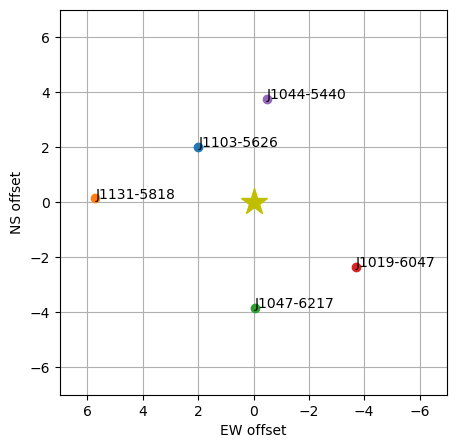

In [7]:
# get sources, get block boundaries

sources0 = splitt(get_file('multiview_control.inp')[9:])
sources1 = []
j = 0
for src in sources0:
    sources1.append(calibrator(src[0],src[1],float(src[2]),float(src[3]),j)); j=j+1

# plot quasar distribution
fig, ax = plt.subplots(1,figsize=(5,5))
for src in sources1:
    ax.plot(src.x,src.y,'o') #,label=src.name)
    ax.text(src.x,src.y,src.name)

ax.grid(True)
ax.plot(0,0,'y*',ms=20)
ax.set_xlim(7,-7)
ax.set_ylim(-7,7)
ax.set_ylabel('NS offset')
ax.set_xlabel('EW offset')
#ax.legend();

mvb_block_boundaries = fday1[np.where(np.diff(fday1)*24*60>30)]+15./(24*60)
N = len(mvb_block_boundaries)+1;

In [8]:
#get reference sources times

ref_sid = 5

with open('target.TBOUT') as w:
    mastbout = w.readlines()

head = np.where(np.array(mastbout) == '***BEGIN*PASS***\n')[0][0]+1
data = np.array([s.split() for s in mastbout[head:-1]])

box = (1,3,4,12,13)
fday0, src_num2, ant_num2, real2, imag2 = data[:,box].T
fday3 = np.array([s.replace('D','E') for s in fday0],dtype='float')

vis2 = np.array(real2,dtype=float)+np.array(imag2,dtype=float)*complex(0,1)
indx_ref = (ant_num2=='3')*(src_num2 == str(ref_sid))
T = fday3[indx_ref]

In [9]:
# make a permutation array to drop quasars

perm = list(product([True,False],repeat=Nquas))
final_perm = []
for i in range(len(perm)):
    if perm[i].count(True)>=3: # at least 3 quasars
        final_perm+=[perm[i]]

#final_perm = [[True,True,True,True,True]]

fp = np.array(final_perm,dtype=bool)

In [10]:
sids = np.unique(src_num1)
cols = ['b','orange','g','r','purple','brown']
colz = {'b':0,'o':1,'g':2,'r':3,'p':4,'br':5}
ants = {1:'CD',2:'HB',3:'KE',4:'WA',5:'YG'}

In [11]:
vis1[(ant_num1 == str('2'))*(src_num1 == sources1[0].sid)];
for v, k in ants.items():
    print(v,k)

1 CD
2 HB
3 KE
4 WA
5 YG


In [26]:
# creating point unwrap structure
point_uwraps = []
for k,v in ants.items():
    s_points = []
    for s in range(len(sources1)):
        indx = (ant_num1 == str(k))*(src_num1 == sources1[s].sid)
        t    = fday1[indx]
        p_raw = rad2deg(1)*np.angle(vis1[indx])
        nboundaryindx = np.zeros(shape=(N-1,))
        for i in range(N-1):
            nboundaryindx[i] = abs( t - mvb_block_boundaries[i]).argmin()
        b_points = []
        for nb in range(N): 
            if nb==0:
                start = 0
                stop  = int(nboundaryindx[0])+1
                b_points.append((p_raw[start:stop]*0.0))
            elif nb!=(N-1):
                # go up for middle blocks
                start = int(nboundaryindx[nb-1])+1
                stop  = int(nboundaryindx[nb])+1
                b_points.append((p_raw[start:stop]*0.0))
            else:
                ## go up for last block
                start = int(nboundaryindx[-1])+1
                b_points.append((0.0*p_raw[start:]))
        s_points.append(b_points)
    point_uwraps.append(s_points)

point_uwraps_save = copy.deepcopy(point_uwraps)

In [27]:
# select antenna for playing

ant = 2
blocks_uwraps  = splitt(get_file('block_{}_unwrapper.inp'.format(ants[ant])))[:,1:].astype(float)
# block, quasar
blocks_uwraps[1,4] = 0
# format ant, quas, block, point
point_uwraps[ant-1][0][0][2] = 0

In [28]:
nboundaryindx

array([ 7., 15.])

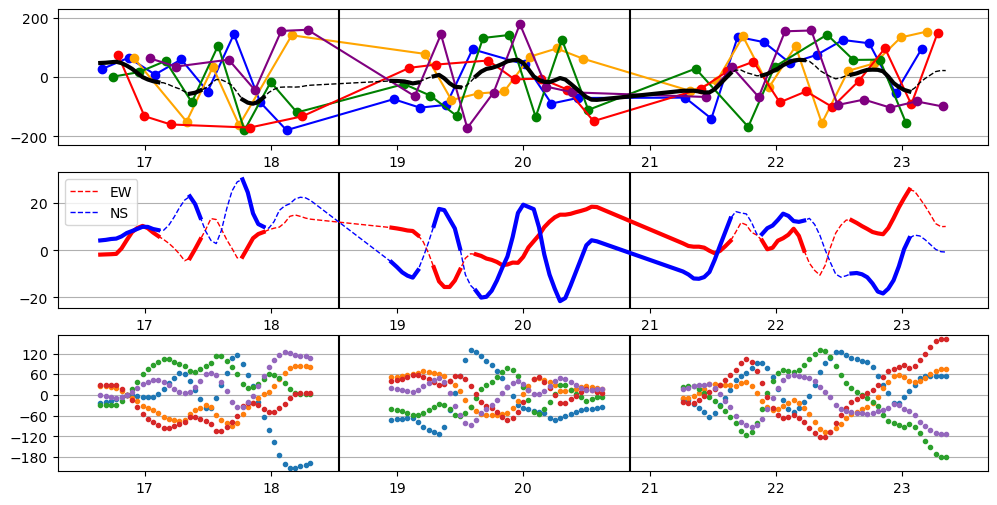

In [98]:
interp_p_raw = []
T_sav, P_raw_sav = [], []

minp, maxp = 0,0

fig, ax = plt.subplots(3,1,figsize=(12,6))
j = 0
for src in sources1:
    indx = (ant_num1 == str(ant))*(src_num1 == src.sid)
    t    = fday1[indx]
    p_raw = rad2deg(1)*np.angle(vis1[indx])
    p_uwp = np.copy(p_raw)
    
    nboundaryindx = np.zeros(shape=(N-1,))
    for i in range(N-1):
       nboundaryindx[i] = abs( t - mvb_block_boundaries[i]).argmin()
    
    for nb in range(N):
        offp = 0
        # block 1        
        if nb==0:
            start = 0
            stop  = int(nboundaryindx[0])+1
            # add in user-defined block unwrap
            p_raw[start:stop] = p_raw[start:stop] + 360*blocks_uwraps[nb,j]
            # add in point-based unwraps
            p_raw[start:stop] = p_raw[start:stop] + 360*point_uwraps[ant-1][src.index][nb]
        elif nb==(N-1):
            #continue
            ## go up for last block
            start = int(nboundaryindx[-1])+1
            p_raw[start:] = p_raw[start:] + 360*blocks_uwraps[-1,j]
            p_raw[start:] = p_raw[start:] + 360*point_uwraps[ant-1][src.index][nb]    
        else:
            #continue
            # go up for middle blocks
            start = int(nboundaryindx[nb-1])+1
            stop  = int(nboundaryindx[nb])+1
            p_raw[start:stop] = p_raw[start:stop] + 360*blocks_uwraps[nb,j]
            p_raw[start:stop] = p_raw[start:stop] + 360*point_uwraps[ant-1][src.index][nb]  
    
    if min(p_raw)<minp:  minp = min(p_raw)
    if max(p_raw)>maxp:  maxp = max(p_raw)
    # now we need to resample the phases at the maser times
    interp_p_raw.append(np.interp(fday3[indx_ref], t, p_raw))
    ax[0].plot(24*t,p_raw,'-o',label=src.name,color=cols[j])
    # save p_raw and p_uwp per quasar
    T_sav.append(fday1[indx])
    P_raw_sav.append(p_raw)
    j = j + 1

ax[0].vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000,color='k')
ax[1].set_yticks(np.arange(-100,100,20)); ax[1].grid(True,axis='y')
ax[2].set_yticks(np.arange(-600,600,60)); ax[2].grid(True,axis='y')
ax[1].vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000,color='k')
ax[2].vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000,color='k')
ax[0].grid(True,axis='y')
ax[0].set_ylim(minp-50,maxp+50)
#ax[0].legend();

P_raw = np.array(interp_p_raw)

l_raw = np.ones(shape=(len(final_perm),3,len(T)))
r_raw = np.ones(shape=(len(final_perm),Nquas,len(T)))
for i in range(len(final_perm)):
    l_raw[i,:,:] = inv(M[final_perm[i],:].T*M[final_perm[i],:])*(M[final_perm[i],:].T*(P_raw[final_perm[i],:]))
    r_raw[i,:,:] = P_raw - M*l_raw[i,:,:]
    r_raw[i,~fp[i],:] = None

# residuals 
R_raw = np.array(P_raw - M*l_raw[0,:,:])

# lambda 

# plot all quasar fit
ax[0].plot(24*T,l_raw[0,0,:],'k--',lw=1)
ax[1].plot(24*T,l_raw[0,1,:],'r--',lw=1,label='EW')
ax[1].plot(24*T,l_raw[0,2,:],'b--',lw=1,label='NS')
ax[1].set_ylim(l_raw[0,1:,:].min()-3,l_raw[0,1:,:].max()+3)
ax[1].legend();

l_raw[:,0,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
l_raw[:,1,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
l_raw[:,2,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
L_raw = np.nanmean(l_raw,axis=0)
ax[0].plot(24*T,l_raw[0,0,:],'k-',lw=3)
ax[1].plot(24*T,l_raw[0,1,:],'r-',lw=3)
ax[1].plot(24*T,l_raw[0,2,:],'b-',lw=3)

# plot nanmean fit
#ax[0].plot(24*T,L_raw[0,:],'k--')
#ax[1].plot(24*T,L_raw[1,:],'r--')
#ax[1].plot(24*T,L_raw[2,:],'b--')
# residuals
for j in range(R_raw.shape[0]):
    ax[2].plot(24*T,R_raw[j,:],'.')
ax[2].set_ylim(R_raw.min()-10,R_raw.max()+10);


In [97]:
# select antenna for playing
ant = 3

del point_uwraps
point_uwraps = copy.deepcopy(point_uwraps_save)

blocks_uwraps  = splitt(get_file('block_{}_unwrapper.inp'.format(ants[ant])))[:,1:].astype(float)
# format: [block, quasar]
# blocks_uwraps[2,4] = -1
# blocks_uwraps[2,0] = -1
# blocks_uwraps[2,2] = 1
# blocks_uwraps[2,3] = 1
# format: [ant, quasar, block, point per block]
# point_uwraps[ant-1][colz['r']][0][1] = 1
# point_uwraps[ant-1][colz['b']][0][2] = -1
# point_uwraps[ant-1][colz['r']][0][6] = -1
# point_uwraps[ant-1][colz['o']][0][4] = 1

# point_uwraps[ant-1][colz['b']][1][1] = -1
# point_uwraps[ant-1][colz['p']][1][6] = 0
# point_uwraps[ant-1][colz['p']][1][3] = 1

# point_uwraps[ant-1][colz['r']][2][0] = 1
# point_uwraps[ant-1][colz['r']][2][1] = 1
# point_uwraps[ant-1][colz['r']][2][2] = 1
# point_uwraps[ant-1][colz['r']][2][4] = 1
# point_uwraps[ant-1][colz['p']][2][4] = 0
# point_uwraps[ant-1][colz['o']][2][2] = 1
# point_uwraps[ant-1][colz['o']][2][4] = 1
# point_uwraps[ant-1][colz['o']][2][7] = 1

point_uwraps_save[ant-1]


[[array([ 0.,  0.,  0.,  0., -0.,  0., -0., -0.]),
  array([-0., -0., -0.,  0.,  0., -0., -0.]),
  array([-0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.])],
 [array([ 0., -0.,  0., -0.,  0.]),
  array([ 0., -0., -0., -0.,  0.,  0.,  0.]),
  array([-0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.])],
 [array([ 0.,  0.,  0., -0.,  0., -0., -0., -0.]),
  array([-0., -0., -0.,  0.,  0., -0.,  0., -0.]),
  array([ 0., -0.,  0.,  0.,  0.,  0., -0.])],
 [array([ 0., -0., -0., -0., -0.]),
  array([ 0.,  0.,  0., -0., -0., -0., -0.]),
  array([-0.,  0.,  0., -0., -0., -0., -0.,  0., -0.,  0.])],
 [array([ 0.,  0.,  0., -0.,  0.,  0.]),
  array([-0.,  0., -0., -0.,  0., -0., -0.]),
  array([-0.,  0., -0.,  0.,  0., -0., -0., -0., -0., -0.])]]

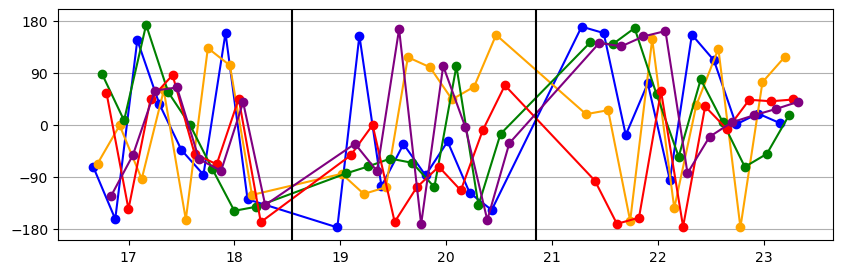

In [16]:
fig, ax = plt.subplots(1,figsize=(10,3))
j = 0
for src in sources1:
    indx = (ant_num1 == str(ant))*(src_num1 == src.sid)
    t    = fday1[indx]
    p_raw = rad2deg(1)*np.angle(vis1[indx])
    p_uwp = np.copy(p_raw)
    ax.plot(24*t,p_uwp,'-o',label=src.name,color=cols[j])
    j = j + 1

ax.vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000,color='k')
ax.set_yticks(np.arange(-7,7.1,1)*90)
ax.grid(True,axis='y')
ax.set_ylim(-200,200);



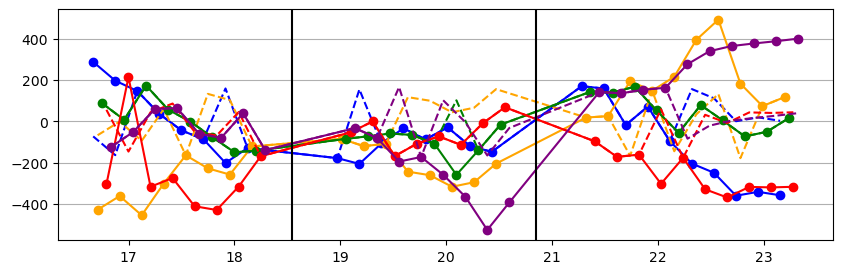

In [74]:
interp_p_raw,interp_p_uwp = [], []
T_sav, P_raw_sav,P_uwp_sav = [], [], []

minp, maxp = 0,0

fig, ax = plt.subplots(1,figsize=(10,3))
j = 0
for src in sources1:
    indx = (ant_num1 == str(ant))*(src_num1 == src.sid)
    t    = fday1[indx]
    p_raw = rad2deg(1)*np.angle(vis1[indx])
    p_uwp = np.copy(p_raw)
    
    nboundaryindx = np.zeros(shape=(N-1,))
    for i in range(N-1):
       nboundaryindx[i] = abs( t - mvb_block_boundaries[i]).argmin()
    
    for nb in range(N):
        offp = 0
        # block 1        
        if nb==0:
            start = 0
            stop  = int(nboundaryindx[0])+1
            # go down from first mbv
            for i in range(p_raw[start:stop].shape[0]-1):
                # dp = shift - reference
                dp = (p_uwp[start:stop][-i-2]-p_uwp[start:stop][-i-1])
                if   dp< -180.0: offp = +360
                elif dp> +180.0: offp = -360
                else: offp = 0.0
                p_uwp[start:stop][-i-2] = p_raw[start:stop][-i-2] + offp
            # zero the average phase
            Dp = p_uwp[start:stop].mean()
            #if   Dp> 181: p_uwp[start:stop] = p_uwp[start:stop] - 360
            #elif Dp<-181: p_uwp[start:stop] = p_uwp[start:stop] + 360
            # add in user-defined block unwrap
            p_uwp[start:stop] = p_uwp[start:stop] + 360*blocks_uwraps[nb,j]
            # add in point-based unwraps
            p_uwp[start:stop] = p_uwp[start:stop] + 360*point_uwraps[ant-1][src.index][nb]
            
        elif nb==(N-1):
            #continue
            ## go up for last block
            start = int(nboundaryindx[-1])+1
            for i in range(p_raw[start:].shape[0]-1):
               dp = (p_uwp[start:][i+1]-p_uwp[start:][i])
               #print dp
               if   dp<-181.0: offp = +360;
               elif dp>+181.0: offp = -360;
               else: offp = 0.0
               p_uwp[start:][i+1] = p_raw[start:][i+1] + offp
            Dp = p_uwp[start:].mean()
            #if   Dp> 181: p_uwp[start:] = p_uwp[start:] - 360
            #elif Dp<-181: p_uwp[start:] = p_uwp[start:] + 360
            p_uwp[start:] = p_uwp[start:] + 360*blocks_uwraps[-1,j]
            p_uwp[start:] = p_uwp[start:] + 360*point_uwraps[ant-1][src.index][nb]            
        else:
            #continue
            # go up for middle blocks
            start = int(nboundaryindx[nb-1])+1
            stop  = int(nboundaryindx[nb])+1
            for i in range(p_raw[start:stop].shape[0]-1):
                dp = p_uwp[start:stop][i+1] -p_uwp[start:stop][i]
                if   dp <-181.0:  
                    offp = +360
                elif dp >+181.0: 
                    offp = -360
                else: offp = 0.0
                p_uwp[start:stop][i+1] = p_raw[start:stop][i+1] + offp
            Dp = p_uwp[start:stop].mean()
            #if   Dp> 181: p_uwp[start:stop] = p_uwp[start:stop] - 360
            #elif Dp<-181: p_uwp[start:stop] = p_uwp[start:stop] + 360
            p_uwp[start:stop] = p_uwp[start:stop] + 360*blocks_uwraps[nb,j]
            p_uwp[start:stop] = p_uwp[start:stop] + 360*point_uwraps[ant-1][src.index][nb]  

    # now we need to resample the phases at the maser times
    interp_p_raw.append(np.interp(fday3[indx_ref], t, p_raw))
    interp_p_uwp.append(np.interp(fday3[indx_ref], t, p_uwp))
    ax.plot(24*t,p_raw,'--',label=src.name,color=cols[j])
    ax.plot(24*t,p_uwp,'-o',label=src.name,color=cols[j])
    if min(p_uwp)<minp:  minp = min(p_uwp)
    if max(p_uwp)>maxp:  maxp = max(p_uwp)
    # save p_raw and p_uwp per quasar
    T_sav.append(fday1[indx])
    P_raw_sav.append(p_raw)
    P_uwp_sav.append(p_uwp)
    j = j + 1

ax.vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000,color='k')
#ax.set_yticks(np.arange(-7,7.1,1)*90)
ax.grid(True,axis='y')
ax.set_ylim(minp-50,maxp+50);
#ax.legend()

P_raw = np.array(interp_p_raw)
P_uwp = np.array(interp_p_uwp)

In [311]:
l_raw = np.ones(shape=(len(final_perm),3,len(T)))
r_raw = np.ones(shape=(len(final_perm),Nquas,len(T)))
for i in range(len(final_perm)):
    l_raw[i,:,:] = inv(M[final_perm[i],:].T*M[final_perm[i],:])*(M[final_perm[i],:].T*P_raw[final_perm[i],:])
    r_raw[i,:,:] = P_raw - M*l_raw[i,:,:]
    r_raw[i,~fp[i],:] = None
# residuals 
R_raw = np.array(P_raw - M*l_raw[0,:,:])
# lambda 
#L1[np.where(np.isnan(l1).sum(0)>l1.shape[0]/2.)] = np.nan
l_raw[:,0,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
l_raw[:,1,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
l_raw[:,2,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
L_raw = np.nanmean(l_raw,axis=0)

# second fit
l_uwp = np.ones(shape=(len(final_perm),3,len(T)))
r_uwp = np.ones(shape=(len(final_perm),Nquas,len(T)))
for i in range(len(final_perm)):
    l_uwp[i,:,:] = inv(M[final_perm[i],:].T*M[final_perm[i],:])*(M[final_perm[i],:].T*P_uwp[final_perm[i],:])
    r_uwp[i,:,:] = P_uwp - M*l_uwp[i,:,:] 
    r_uwp[i,~fp[i],:] = None

# residuals 
R_uwp = np.array(P_uwp - M*l_uwp[0,:,:])
# lambda 
#L2[np.where(np.isnan(l2).sum(0)>l2.shape[0]/2.)] = np.nan
l_uwp[:,0,:][np.where(np.nanmean(abs(r_uwp),axis=1)>rad2deg(1))] = None
l_uwp[:,1,:][np.where(np.nanmean(abs(r_uwp),axis=1)>rad2deg(1))] = None
l_uwp[:,2,:][np.where(np.nanmean(abs(r_uwp),axis=1)>rad2deg(1))] = None
L_uwp = np.nanmean(l_uwp,axis=0)

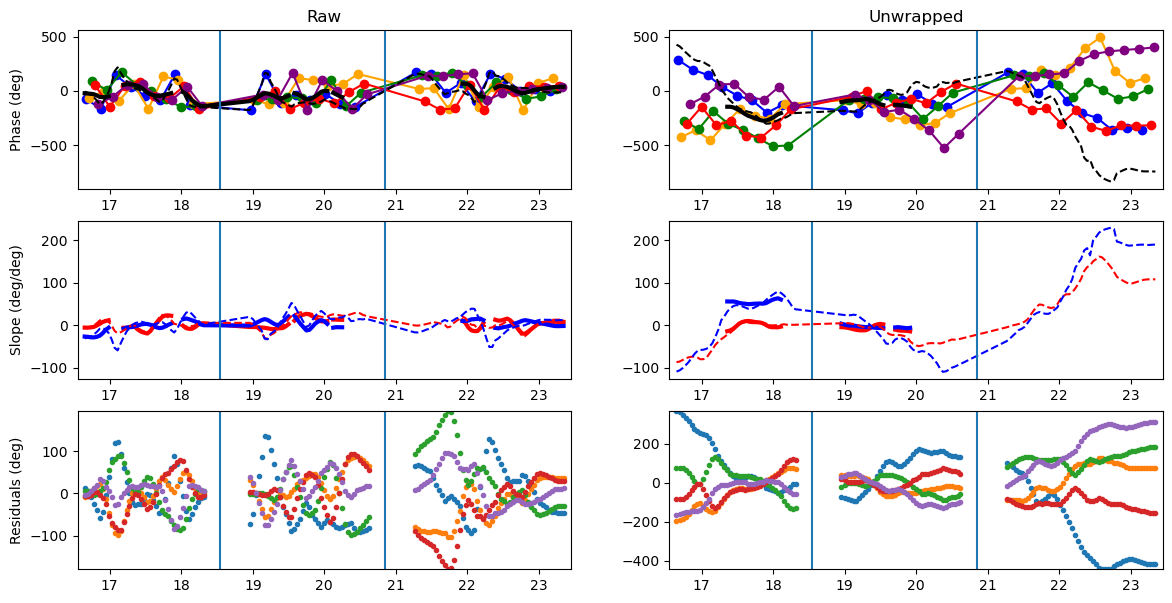

In [312]:
fig, ax = plt.subplots(3,2,figsize=(14,7))

j = 0 
for src in sources1:
    # plot to un-resampled/un-interpolated data 
    ax[0,0].plot(24*T_sav[j],P_raw_sav[j],'-o',label=src.name,color=cols[j])
    ax[0,1].plot(24*T_sav[j],P_uwp_sav[j],'-o',label=src.name,color=cols[j])
    j = j + 1

# plot input data
for k,l,P,L,R in zip([0,1],[l_raw,l_uwp],[P_raw,P_uwp],[L_raw,L_uwp],[R_raw,R_uwp]):
    #for j in range(P.shape[0]):
    #    ax[0,k].plot(24*T,P[j,:],'.')

    # plot all quasar fit
    ax[0,k].plot(24*T,l[0,0,:],'k-',lw=3)
    ax[1,k].plot(24*T,l[0,1,:],'r-',lw=3)
    ax[1,k].plot(24*T,l[0,2,:],'b-',lw=3)
    # plot nanmean fit
    ax[0,k].plot(24*T,L[0,:],'k--')
    ax[1,k].plot(24*T,L[1,:],'r--')
    ax[1,k].plot(24*T,L[2,:],'b--')
    # plot all fits
    #for i in range(l2.shape[0]):
    #    ax[0,k].plot(24*T,l[i,0,:],'k-',lw=0.3)
    #    ax[1,k].plot(24*T,l[i,1,:],'r-',lw=0.1)
    #    ax[1,k].plot(24*T,l[i,2,:],'b-',lw=0.1)
    # plot residuals
    for j in range(R.shape[0]):
        ax[2,k].plot(24*T,R[j,:],'.')
    ax[2,k].set_ylim(R.min(),R.max())

# now fix top and bottom axes
y00 = ax[0,0].axes.get_ylim()
y01 = ax[0,1].axes.get_ylim()
y10 = ax[1,0].axes.get_ylim()
y11 = ax[1,1].axes.get_ylim()

# scale both top yaxes
for AX in ax[0,:]:
    AX.set_ylim(min([y00[0],y01[0]]),max(y00[1],y01[1]))
# scale both bottom yaxes
for AX in ax[1,:]:
    AX.set_ylim(min([y10[0],y11[0]]),max(y10[1],y11[1]))
# scale all xaxes
for AX in ax.flatten():
    AX.set_xlim(24*T[0]-.1,24*T[-1]+.1)
    AX.vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000)

ax[0,0].title.set_text('Raw');
ax[0,1].title.set_text('Unwrapped');
ax[0,0].set_ylabel('Phase (deg)');
ax[1,0].set_ylabel('Slope (deg/deg)');
ax[2,0].set_ylabel('Residuals (deg)');


In [309]:
# time for some adjustable unwrapping

ant = 2
cols = ['b','orange','g','r','purple','brown']
blocks_uwraps  = splitt(get_file('block_{}_unwrapper.inp'.format(ants[ant])))[:,1:].astype(float)
# format block, quas
blocks_uwraps[0,2] = -1
# format ant, quas, block, point
point_uwraps[ant-1][0][0][2] =  0


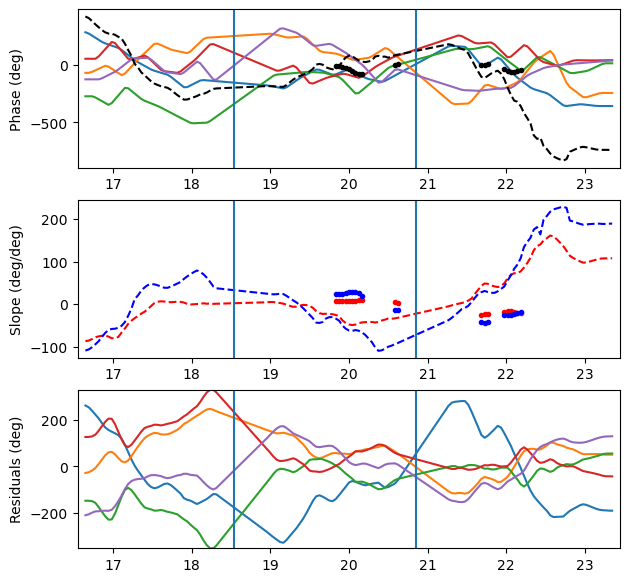

In [313]:
interp_p_raw,interp_p_uwp,t_raw,p_auwp = [],[],[],[]
j = 0
for src in sources1:
    indx = (ant_num1 == str(ant))*(src_num1 == src.sid)
    t    = fday1[indx]
    p_raw = rad2deg(1)*np.angle(vis1[indx])
    p_uwp = np.copy(p_raw)
    
    nboundaryindx = np.zeros(shape=(N-1,))
    for i in range(N-1):
       nboundaryindx[i] = abs( t - mvb_block_boundaries[i]).argmin()
    
    for nb in range(N):
        offp = 0        
        if nb==0:
            start = 0
            stop  = int(nboundaryindx[0])+1
            # go down from first mbv
            for i in range(p_raw[start:stop].shape[0]-1):
                dp = (p_uwp[start:stop][-i-2]-p_uwp[start:stop][-i-1])
                #print dp
                if   dp <-181.0: offp = +360
                elif dp >+181.0: offp = -360
                else: offp = 0.0
                p_uwp[start:stop][-i-2] = p_raw[start:stop][-i-2] + offp
            # zero the average phase
            Dp = p_uwp[start:stop].mean()
            if   Dp> 181: p_uwp[start:stop] = p_uwp[start:stop] - 360
            elif Dp<-181: p_uwp[start:stop] = p_uwp[start:stop] + 360
            # add in user-defined block unwrap
            p_uwp[start:stop] = p_uwp[start:stop] + 360*blocks_uwraps[nb,j]
            # add in point-based unwraps
            p_uwp[start:stop] = p_uwp[start:stop] + 360*point_uwraps[ant-1][src.index][nb]
            
        elif nb==(N-1):
            ## go up for last block
            start = int(nboundaryindx[-1])+1
            for i in range(p_raw[start:].shape[0]-1):
               dp = (p_uwp[start:][i+1]-p_uwp[start:][i])
               #print dp
               if   dp<-181.0: offp = +360;
               elif dp>+181.0: offp = -360;
               else: offp = 0.0
               p_uwp[start:][i+1] = p_raw[start:][i+1] + offp
            Dp = p_uwp[start:].mean()
            if   Dp> 181: p_uwp[start:] = p_uwp[start:] - 360
            elif Dp<-181: p_uwp[start:] = p_uwp[start:] + 360
            p_uwp[start:] = p_uwp[start:]     + 360*blocks_uwraps[-1,j]
            p_uwp[start:] = p_uwp[start:] + 360*point_uwraps[ant-1][src.index][nb]            
        else:
            # go up for middle blocks
            start = int(nboundaryindx[nb-1])+1
            stop  = int(nboundaryindx[nb])+1
            for i in range(p_raw[start:stop].shape[0]-1):
                dp = p_uwp[start:stop][i+1] -p_uwp[start:stop][i]
                if   dp <-181.0:  
                    offp = +360
                elif dp >+181.0: 
                    offp = -360
                else: offp = 0.0
                p_uwp[start:stop][i+1] = p_raw[start:stop][i+1] + offp
            Dp = p_uwp[start:stop].mean()
            if   Dp> 181: p_uwp[start:stop] = p_uwp[start:stop] - 360
            elif Dp<-181: p_uwp[start:stop] = p_uwp[start:stop] + 360
            p_uwp[start:stop] = p_uwp[start:stop] + 360*blocks_uwraps[nb,j]
            p_uwp[start:stop] = p_uwp[start:stop] + 360*point_uwraps[ant-1][src.index][nb]  
            
    # now we need to resample the phases at the maser times
    t_raw.append(t)
    p_auwp.append(p_uwp)
    interp_p_raw.append(np.interp(fday3[indx_ref], t, p_raw))
    interp_p_uwp.append(np.interp(fday3[indx_ref], t, p_uwp))
    j = j + 1

P_uwp  = np.array(p_auwp)
P_iraw = np.array(interp_p_raw)
P_iuwp = np.array(interp_p_uwp)

l_raw = np.ones(shape=(len(final_perm),3,len(T)))
r_raw = np.ones(shape=(len(final_perm),Nquas,len(T)))
for i in range(len(final_perm)):
    l_raw[i,:,:] = inv(M[final_perm[i],:].T*M[final_perm[i],:])*(M[final_perm[i],:].T*P_iraw[final_perm[i],:])
    r_raw[i,:,:] = P_iraw - M*l_raw[i,:,:]
    r_raw[i,~fp[i],:] = None
# residuals 
R_iraw = np.array(P_iraw - M*l_raw[0,:,:])
# lambda 
#L1[np.where(np.isnan(l1).sum(0)>l1.shape[0]/2.)] = np.nan
l_raw[:,0,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
l_raw[:,1,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
l_raw[:,2,:][np.where(np.nanmean(abs(r_raw),axis=1)>rad2deg(1))] = None
L_raw = np.nanmean(l_raw,axis=0)

# second fit
l_iuwp = np.ones(shape=(len(final_perm),3,len(T)))
r_iuwp = np.ones(shape=(len(final_perm),Nquas,len(T)))
for i in range(len(final_perm)):
    l_iuwp[i,:,:] = inv(M[final_perm[i],:].T*M[final_perm[i],:])*(M[final_perm[i],:].T*P_iuwp[final_perm[i],:])
    r_iuwp[i,:,:] = P_iuwp - M*l_iuwp[i,:,:] 
    r_iuwp[i,~fp[i],:] = None
# residuals 
R_uwp = []
# interpolated residuals
R_iuwp = np.array(P_iuwp - M*l_iuwp[0,:,:])
#get per-actual data point fit residual
for i in range(Nquas):
    R_uwp.append(np.interp(t_raw[i],T,R_iuwp[i,:]))


# lambda 
#L2[np.where(np.isnan(l2).sum(0)>l2.shape[0]/2.)] = np.nan
l_iuwp[:,0,:][np.where(np.nanmean(abs(r_iuwp),axis=1)>rad2deg(1))] = None
l_iuwp[:,1,:][np.where(np.nanmean(abs(r_iuwp),axis=1)>rad2deg(1))] = None
l_iuwp[:,2,:][np.where(np.nanmean(abs(r_iuwp),axis=1)>rad2deg(1))] = None
L_iuwp = np.nanmean(l_iuwp,axis=0)

doubles = 1
fig, ax = plt.subplots(3,doubles,figsize=(7*doubles,7))
ax = ax.reshape(3,1)
# plot input data
#for k,l,P,L,R in zip([0,1],[l_raw,l_iuwp],[P_iraw,P_iuwp],[L_raw,L_uwp],[R_iraw,R_iuwp]):
for k,l,P,L,R in zip([0],[l_iuwp],[P_iuwp],[L_uwp],[R_iuwp]):
    for j in range(P.shape[0]):
        ax[0,k].plot(24*T,P[j,:],'-')
    # plot all quasar fit
    ax[0,k].plot(24*T,l[0,0,:],'k.',lw=3)
    ax[1,k].plot(24*T,l[0,1,:],'r.',lw=3)
    ax[1,k].plot(24*T,l[0,2,:],'b.',lw=3)
    # plot nanmean fit
    ax[0,k].plot(24*T,L[0,:],'k--')
    ax[1,k].plot(24*T,L[1,:],'r--')
    ax[1,k].plot(24*T,L[2,:],'b--')
    # plot all fits
    #for i in range(l2.shape[0]):
    #    ax[0,k].plot(24*T,l[i,0,:],'k-',lw=0.3)
    #    ax[1,k].plot(24*T,l[i,1,:],'r-',lw=0.1)
    #    ax[1,k].plot(24*T,l[i,2,:],'b-',lw=0.1)
    # plot residuals
    for j in range(R.shape[0]):
        ax[2,k].plot(24*T,R[j,:],'-')
    ax[2,k].set_ylim(R.min(),R.max())

#for i in range(Nquas):
#    ax[-1,-1].plot(24*t_raw[i],R_uwp[i],'o',color=cols[i])

# now fix top and bottom axes
y00 = ax[0,0].axes.get_ylim()
y01 = ax[0,-1].axes.get_ylim()
y10 = ax[1,0].axes.get_ylim()
y11 = ax[1,-1].axes.get_ylim()

# scale both top yaxes
for AX in ax[0,:]:
    AX.set_ylim(min([y00[0],y01[0]]),max(y00[1],y01[1]))
# scale both bottom yaxes
for AX in ax[1,:]:
    AX.set_ylim(min([y10[0],y11[0]]),max(y10[1],y11[1]))
# scale all xaxes
for AX in ax.flatten():
    AX.set_xlim(24*T[0]-.1,24*T[-1]+.1)
    AX.vlines(x=24*mvb_block_boundaries,ymin=-1000,ymax=1000)

a#x[0,0].title.set_text('Raw');
#ax[0,1].title.set_text('Unwrapped');
ax[0,0].set_ylabel('Phase (deg)');
ax[1,0].set_ylabel('Slope (deg/deg)');
ax[2,0].set_ylabel('Residuals (deg)');


In [59]:
blocks_uwraps 

# blue
point_uwraps[ant-1][0][0][2] =  1
point_uwraps[ant-1][0][0][6] = 0
point_uwraps[ant-1][0][0][7] = -1

point_uwraps[ant-1][0][1][0] = -1
point_uwraps[ant-1][0][1][1] = 0

point_uwraps[ant-1][0][2][0] = 0

# orange
point_uwraps[ant-1][1][2][0] = -1

# green
point_uwraps[ant-1][2][0][6] = 1

# red 
point_uwraps[ant-1][3][1][-1] = 1
point_uwraps[ant-1][3][2][0] = 0

# purple
point_uwraps[ant-1][4][0][7] = -1
point_uwraps[ant-1][4][1][5] =  1
point_uwraps[ant-1][4][1][6] =  1

point_uwraps[ant-1][4][2][0] =  1

# brown


IndexError: index 6 is out of bounds for axis 0 with size 6